In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import re


In [2]:
#把id转换成可读字符串
#参考：https://github.com/tensorflow/models/blob/1af55e018eebce03fb61bba9959a04672536107d/tutorials/image/imagenet/classify_image.py
class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = 'models/imagenet_2012_challenge_label_map_proto.pbtxt'
    if not uid_lookup_path:
      uid_lookup_path = 'models/imagenet_synset_to_human_label_map.txt'
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.
    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.
    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]


In [3]:
#加载解码的图像 这里是个大坑 tf提供的imagenet预训练好的模型pb文件中 包含针对图像的预处理环节 即解码jpg文件 这部分没有梯度
#需要直接处理解码后的数据
session=tf.Session()

target = tf.placeholder(tf.int32)


def create_graph(dirname):
    with tf.gfile.FastGFile(dirname, 'rb') as f:
        graph_def = session.graph_def
        graph_def.ParseFromString(f.read())

        _ = tf.import_graph_def(graph_def, name='')

#从'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'下载并解压到指定路径
create_graph("models/classify_image_graph_def.pb")

# 初始化参数  非常重要
session.run(tf.global_variables_initializer())
tensorlist=[n.name for n in session.graph_def.node]

#print(tensorlist)

#这里注意 一定要查看下当前tensor的名称再写 因为导入pb时指定了名称前缀adv
softmax_tensor = session.graph.get_tensor_by_name('softmax:0')
input_tensor=session.graph.get_tensor_by_name('ExpandDims:0')
logits_tensor=session.graph.get_tensor_by_name('softmax/logits:0')


In [4]:
imagename="../picture/cropped_panda.jpg"

image=np.array(Image.open(imagename).convert('RGB')).astype(np.float32)
#[100,100,3]->[1,100,100,3]
image=np.expand_dims(image, axis=0)

predictions = session.run(softmax_tensor,
                           {input_tensor: image})
predictions = np.squeeze(predictions)

# Creates node ID --> English string lookup.
node_lookup = NodeLookup()

#top 3
top_k = predictions.argsort()[-3:][::-1]
for node_id in top_k:
    human_string = node_lookup.id_to_string(node_id)
    score = predictions[node_id]
    print('%s (score = %.5f)(id = %d)' % (human_string, score,node_id))

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (score = 0.89233)(id = 169)
indri, indris, Indri indri, Indri brevicaudatus (score = 0.00859)(id = 75)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (score = 0.00264)(id = 7)


In [5]:
epochs=50
e=1.0
original_label=169
target_label=288


loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_tensor, labels=[target])
grad, = tf.gradients(loss, input_tensor)

session.run(tf.global_variables_initializer())

adv_img=image.copy()
node_lookup = NodeLookup()

for epoch in range(epochs):
    
    s,g,l=session.run([softmax_tensor,grad,loss],{target:target_label,input_tensor:adv_img})
    
    
    adv_img=adv_img-e*np.sign(g)
    
    predictions = np.squeeze(s)

    top_k = predictions.argsort()[-3:][::-1]
    
    predictions_id=top_k[0]
    
    print("epoch={} loss={} label={}".format(epoch,l,predictions_id))
    
    if predictions_id == target_label:
        for node_id in top_k:
            human_string = node_lookup.id_to_string(node_id)
            score = predictions[node_id]
            print('%s (score = %.5f)(id = %d)' % (human_string, score,node_id))
        break
    
    

epoch=0 loss=[9.84747] label=169
epoch=1 loss=[7.9263983] label=75
epoch=2 loss=[7.916902] label=169
epoch=3 loss=[6.8320932] label=75
epoch=4 loss=[5.5340815] label=169
epoch=5 loss=[4.460303] label=75
epoch=6 loss=[3.4092696] label=169
epoch=7 loss=[2.482861] label=75
epoch=8 loss=[0.38850152] label=288
snowmobile (score = 0.67807)(id = 288)
motor scooter, scooter (score = 0.01814)(id = 260)
moped (score = 0.01161)(id = 277)


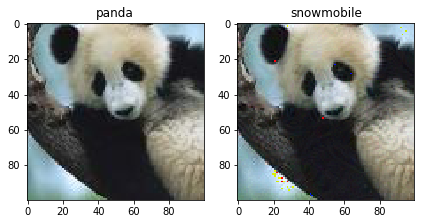

In [8]:
from matplotlib import pyplot as plt

image=image.astype(np.uint8)
adv_img=adv_img.astype(np.uint8)

plt.subplot(121)
plt.imshow(image[0]) 
plt.title("panda")

plt.subplot(122)
plt.imshow(adv_img[0]) 
plt.title("snowmobile")


plt.tight_layout()